変更点
- Softmaxを温度付きSoftmaxに変更


In [1]:
# smt-layerの追加

# Actor-Critic for Grid-World

## smt-layerのimport
import sys
from pathlib import Path
import os
sys.path.append(os.path.abspath(os.path.join(Path().resolve(), '..')))

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import z3
from smtlayer import SMTLayer


In [2]:

class GridWorld:
    def __init__(self, size=4, pitfall_positions=None):
        self.size = size
        self.goal = [size-1, size-1]
        self.pitfall_positions = pitfall_positions if pitfall_positions else []
        self.reset()

    def reset(self):
        self.state = np.zeros((self.size, self.size))
        self.state[0, 0] = 1
        self.done = False
        self.pos = [0, 0]
        return self.state.flatten()

    def step(self, action):
        if self.done:
            raise ValueError("Game is done")
        
        moves = [(-1, 0), (0, 1), (0, -1), (1, 0)]  # Left, Down, Up, Right
        dx, dy = moves[action]
        new_x, new_y = self.pos[0] + dx, self.pos[1] + dy
        
        if 0 <= new_x < self.size and 0 <= new_y < self.size:
            self.pos = [new_x, new_y]
        
        self.state = np.zeros((self.size, self.size))
        self.state[self.pos[0], self.pos[1]] = 1
        
        reward = -1
        if self.pos == self.goal:
            reward = 150
            self.done = True
        elif self.pos in self.pitfall_positions:
            reward = -150
            self.done = True
        
        return self.state.flatten(), reward, self.done


In [3]:
class ActorCriticWithSat(nn.Module):
    def __init__(self, state_size, grid_size, pitfalls, action_size, hidden_size=64, use_maxsmt=False, temperature=1.0):
        super(ActorCriticWithSat, self).__init__()
        self.grid_size = grid_size
        self.pitfalls = pitfalls
        self.temperature = temperature
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc_actor = nn.Linear(hidden_size, action_size)
        self.fc_critic = nn.Linear(hidden_size, 1)

        self.sat = self._create_smt_layer(use_maxsmt)
    
    def _create_smt_layer(self, use_maxsmt):
        inputs = z3.Bools('v0 v1 v2 v3 v4 v5 v6 v7')
        outputs = z3.Bools('v8 v9 v10 v11')
        x0, x1, x2, x3, x4, x5, x6, x7 = inputs
        y0, y1, y2, y3 = outputs
        z1, z2, y = z3.BitVecs('z1 z2 y', 4)
        
        # z1にx0-3(feature)を代入
        cl9 = z1 == z3.Concat(z3.If(x0, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x1, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x2, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                              z3.If(x3, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)))
        # z2にx4-7(allowed_direction)を代入
        cl10 = z2 == z3.Concat(z3.If(x4, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x5, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x6, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)),
                               z3.If(x7, z3.BitVecVal(1, 1), z3.BitVecVal(0, 1)))
        cl11 = y == (z1 & z2)
        cl12 = y3 == (z3.Extract(0, 0, y) == z3.BitVecVal(1, 1))
        cl13 = y2 == (z3.Extract(1, 1, y) == z3.BitVecVal(1, 1))
        cl14 = y1 == (z3.Extract(2, 2, y) == z3.BitVecVal(1, 1))
        cl15 = y0 == (z3.Extract(3, 3, y) == z3.BitVecVal(1, 1))

        # y0, y1, y2, y3のどれか一つだけが1である制約
        # cl16 = z3.PbEq([(y0, 1), (y1, 1), (y2, 1), (y3, 1)], 1)

        clauses = [cl9,cl10,cl11,cl12,cl13,cl14,cl15]

        mask = torch.tensor([1.] * 8 + [0.] * 4)
        
        return SMTLayer(
            input_size=8,
            output_size=4,
            variables=inputs+outputs,
            theory=clauses,
            default_mask=mask,
            solverop='smt' if not use_maxsmt else 'maxsmt')
    
    def forward(self, x, pos, return_sat=True, do_maxsat=False):
        x = F.relu(self.fc1(x))
        actor_output = self.fc_actor(x)
        if return_sat:
            pads = torch.zeros((actor_output.shape[0], 4), dtype=actor_output.dtype, device=actor_output.device)
            allowed_direction = self.allowed_direction(pos)
            allowed_direction = allowed_direction.unsqueeze(0).repeat(actor_output.shape[0], 1)
            combined = torch.cat([actor_output, allowed_direction, pads], dim=1)
            actor_output = self.sat(combined, do_maxsat_forward=do_maxsat)
        
        # 温度付きSoftmax
        actor_output = F.softmax(actor_output / self.temperature, dim=1)


        critic_output = self.fc_critic(x)
        return actor_output, critic_output
    
    def allowed_direction(self, pos):
        x, y = pos
        allowed = torch.ones(4)
        if x == 0: allowed[0] = -1 # Left
        if y == self.grid_size - 1: allowed[1] = -1 # Down
        if y == 0: allowed[2] = -1 # Up
        if x == self.grid_size - 1: allowed[3] = -1 # Right

        # 落とし穴の周辺にいる場合、その方向に進めないようにする
        for pitfall in self.pitfalls:
            px, py = pitfall
            if [x - 1, y] == pitfall:  # 左に落とし穴がある場合
                allowed[0] = -1
            if [x, y + 1] == pitfall:  # 下に落とし穴がある場合
                allowed[1] = -1
            if [x, y - 1] == pitfall:  # 上に落とし穴がある場合
                allowed[2] = -1
            if [x + 1, y] == pitfall:  # 右に落とし穴がある場合
                allowed[3] = -1

        return allowed

In [4]:
class Agent:
    def __init__(self, state_size, grid_size, pitfalls, action_size, gamma=0.99, lr=0.001, epsilon=0.1, temperature=1.0):
        self.actor_critic = ActorCriticWithSat(state_size, grid_size, pitfalls, action_size, temperature=temperature)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_size = action_size
    
    def select_action(self, state, pos, deterministic=False):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs, _ = self.actor_critic(state, pos)
        
        m = torch.distributions.Categorical(probs)
        action = m.sample() if not deterministic else torch.argmax(probs)
        return action.item(), m.log_prob(action)

    def update(self, log_probs, values, rewards, next_value, dones):
        Qvals = self._compute_qvals(rewards, next_value, dones)
        
        Qvals = torch.tensor(Qvals)
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        
        actor_loss = (-log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return actor_loss.item(), critic_loss.item()

    def _compute_qvals(self, rewards, next_value, dones):
        Qvals = np.zeros(len(rewards))
        Qval = next_value
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + self.gamma * Qval * (1 - dones[t])
            Qvals[t] = Qval
        return Qvals

In [5]:

def train(env, agent, n_episodes=1000, max_t=30):
    scores, actor_losses, critic_losses, Q_values = [], [], [], []

    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        log_probs, values, rewards, dones = [], [], [], []
        
        for t in range(max_t):
            action, log_prob = agent.select_action(state, pos=env.pos)
            next_state, reward, done = env.step(action)
            
            log_probs.append(log_prob)
            values.append(agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0), tuple(env.pos))[1])
            rewards.append(reward)
            dones.append(done)
            
            state = next_state
            
            if done:
                break

        next_value = agent.actor_critic(torch.from_numpy(state).float().unsqueeze(0), tuple(env.pos))[1].detach()
        
        actor_loss, critic_loss = agent.update(log_probs, values, rewards, next_value, dones)
        
        scores.append(sum(rewards))
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)
        Q_values.append(np.mean(agent._compute_qvals(rewards, next_value, dones)))
        
        if i_episode % 100 == 0:
            print(f"Episode {i_episode}/{n_episodes}, Average Score: {np.mean(scores[-100:])}, Actor Loss: {actor_loss}, Critic Loss: {critic_loss}")

    return scores, actor_losses, critic_losses, Q_values

def plot_results(scores, actor_losses, critic_losses, Q_values, window_size=100):
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(moving_average(scores, window_size))
    plt.title('Total Rewards per Episode (Smoothed)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(2, 2, 2)
    plt.plot(moving_average(actor_losses, window_size))
    plt.title('Actor Loss (Smoothed)')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 3)
    plt.plot(moving_average(critic_losses, window_size))
    plt.title('Critic Loss (Smoothed)')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(2, 2, 4)
    plt.plot(moving_average(Q_values, window_size))
    plt.title('Average Q-value (Smoothed)')
    plt.xlabel('Episode')
    plt.ylabel('Q-value')

    plt.tight_layout()
    plt.show()

def get_policy(agent, env: GridWorld):
    policy = np.zeros((env.size, env.size), dtype=int)
    for i in range(env.size):
        for j in range(env.size):
            state = np.zeros((env.size, env.size))
            state[i, j] = 1
            state = state.flatten()
            action, _ = agent.select_action(state, [i, j], deterministic=True)
            policy[i, j] = action
    return policy

def plot_policy(policy, env: GridWorld):
    direction = {0: '<', 1: '>', 2: '^', 3: 'v'}
    policy_grid = np.vectorize(direction.get)(policy)
    for i in range(env.size):
        for j in range(env.size):
            if [i, j] == env.goal:
                policy_grid[i, j] = 'G'
            elif [i, j] in env.pitfall_positions:
                policy_grid[i, j] = 'X'
    print(policy_grid)

def visualize_episode(agent, env: GridWorld, max_t=300):
    state = env.reset()
    path = [env.pos.copy()]
    
    for i in range(max_t):
        action, _ = agent.select_action(state, env.pos, deterministic=False)
        state, _, done = env.step(action)
        path.append(env.pos.copy())
        if done:
            print(f"{i}回で終了")
            break
    
    return path

def plot_path(path, env):
    grid = np.full((env.size, env.size), '-', dtype=str)
    
    for position in path:
        grid[position[0], position[1]] = 'o'
    
    for pitfall in env.pitfall_positions:
        grid[pitfall[0], pitfall[1]] = 'X'
    
    grid[env.goal[0], env.goal[1]] = 'G'
    grid[0, 0] = 'S'
    
    print(grid)


# 落とし穴なし

In [14]:

# Setup environment and agent
env = GridWorld(size=4, pitfall_positions=None)
state_size = env.size * env.size
action_size = 4
temperature = 0.5
agent = Agent(state_size, env.size, env.pitfall_positions, action_size, temperature=temperature)

# Train the agent
max_t = 30
scores, actor_losses, critic_losses, Q_values = train(env, agent, n_episodes=2000, max_t=max_t) 

Episode 100/2000, Average Score: 143.37, Actor Loss: 39.14482776517098, Critic Loss: 20187.886353554903
Episode 200/2000, Average Score: 140.46, Actor Loss: 37.71476799831796, Critic Loss: 18741.12433980395
Episode 300/2000, Average Score: 144.18, Actor Loss: 6.723086706269478, Critic Loss: 15815.480967462217
Episode 400/2000, Average Score: 144.55, Actor Loss: 5.832059304120321, Critic Loss: 11906.559907549854
Episode 500/2000, Average Score: 144.69, Actor Loss: 4.766059282369152, Critic Loss: 7959.094195999027
Episode 600/2000, Average Score: 144.53, Actor Loss: 3.6472758979721505, Critic Loss: 4670.374079056336
Episode 700/2000, Average Score: 144.64, Actor Loss: 2.5869710723427413, Critic Loss: 2361.0413811664234
Episode 800/2000, Average Score: 144.49, Actor Loss: 1.6824928524746952, Critic Loss: 1011.5235644716498
Episode 900/2000, Average Score: 144.65, Actor Loss: 0.9930888263052893, Critic Loss: 366.71953170974547
Episode 1000/2000, Average Score: 144.48, Actor Loss: 0.5345468

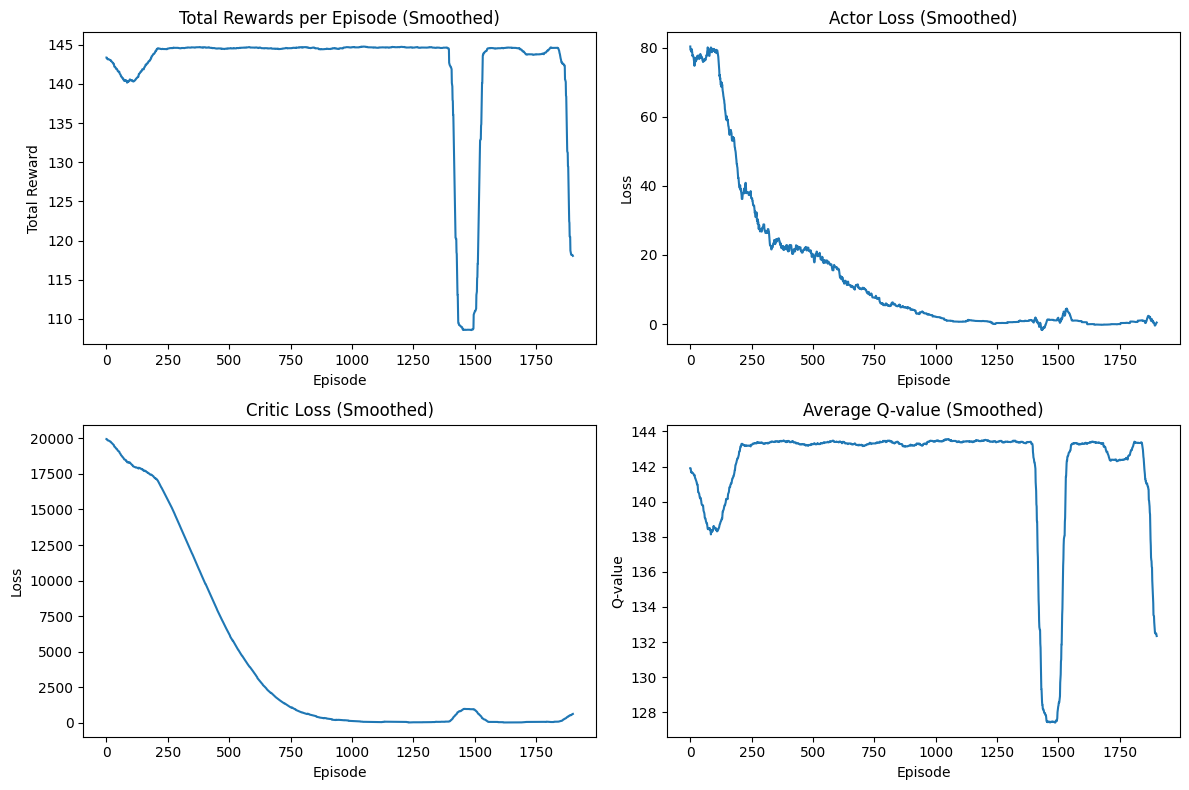

In [15]:

# Plot results
plot_results(scores, actor_losses, critic_losses, Q_values)


In [16]:

# Visualize policy
policy = get_policy(agent, env)
plot_policy(policy, env)


[['>' '>' '>' '<']
 ['<' '>' '>' 'v']
 ['>' '>' '>' '<']
 ['>' '<' '>' 'G']]


In [17]:

# Visualize deterministic episode
path = visualize_episode(agent, env)
plot_path(path, env)

7回で終了
[['S' '-' '-' '-']
 ['o' '-' '-' '-']
 ['o' 'o' 'o' 'o']
 ['-' 'o' '-' 'G']]


# 落とし穴あり

In [18]:

## 落とし穴を含む環境とエージェントの設定
# 落とし穴の位置を指定（例として[2, 2]に設置）
pitfall_positions = [[2, 2]] # 落とし穴の位置を指定
env = GridWorld(size=4, pitfall_positions=pitfall_positions)
# env = GridWorld(size=4, pitfall_positions=None)
state_size = env.size * env.size
action_size = 4
temperature = 0.5
agent = Agent(state_size, env.size, env.pitfall_positions, action_size, temperature=temperature)

# Train the agent
max_t = 30
scores, actor_losses, critic_losses, Q_values = train(env, agent, n_episodes=2000, max_t=max_t)

Episode 100/2000, Average Score: 13.9, Actor Loss: -14.3162310385158, Critic Loss: 255.80135507926124
Episode 200/2000, Average Score: 43.27, Actor Loss: 118.36007787969531, Critic Loss: 20363.21347627185
Episode 300/2000, Average Score: 120.52, Actor Loss: -281.5580112533079, Critic Loss: 23793.243126497717
Episode 400/2000, Average Score: 132.69, Actor Loss: 120.28259570940685, Critic Loss: 15581.019780161889
Episode 500/2000, Average Score: 132.77, Actor Loss: 5.8232897767543665, Critic Loss: 11874.053108985598
Episode 600/2000, Average Score: 138.69, Actor Loss: 4.61202936789438, Critic Loss: 7456.4364546972165
Episode 700/2000, Average Score: 144.73, Actor Loss: 37.69750938344155, Critic Loss: 3667.687861882668
Episode 800/2000, Average Score: 135.58, Actor Loss: 69.23012729836081, Critic Loss: 3115.944612243404
Episode 900/2000, Average Score: 144.6, Actor Loss: 15.776559900687246, Critic Loss: 968.7652975515957
Episode 1000/2000, Average Score: 138.6, Actor Loss: 0.9544067236858

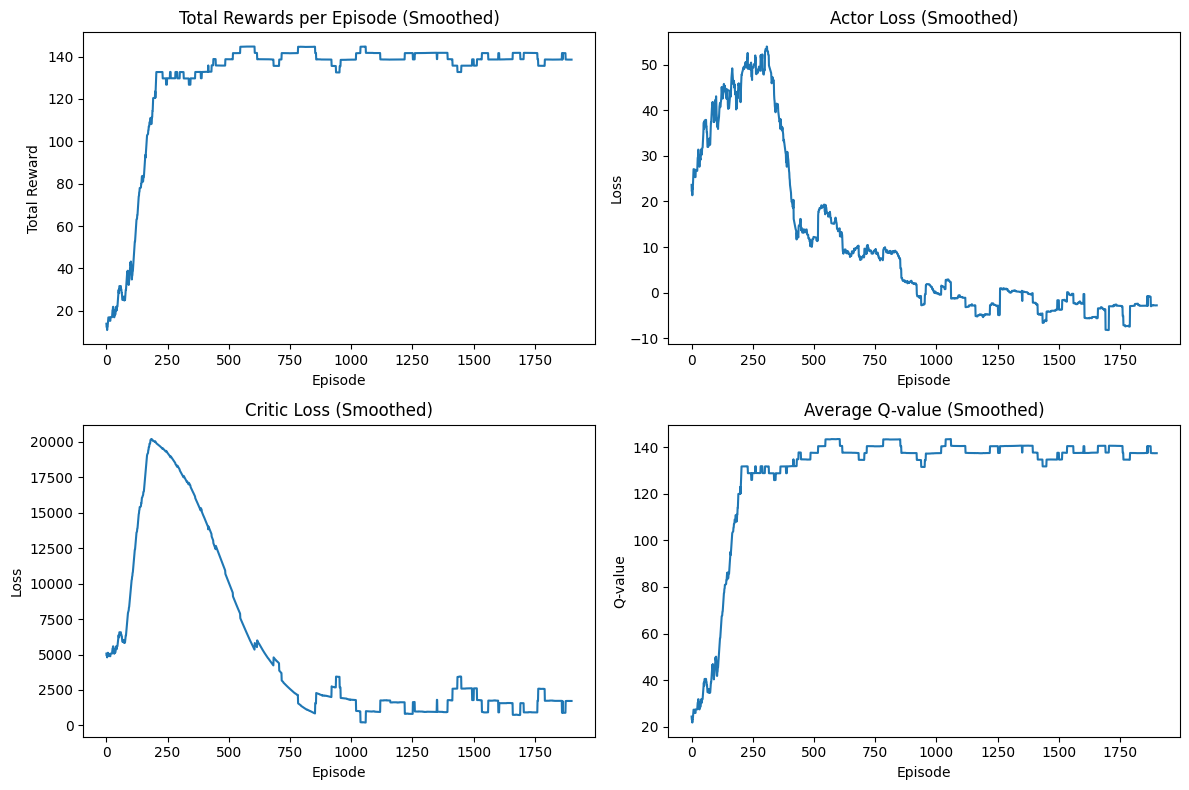

In [19]:

# Plot results
plot_results(scores, actor_losses, critic_losses, Q_values)


In [20]:

# Visualize policy
policy = get_policy(agent, env)
plot_policy(policy, env)


[['>' '>' '>' 'v']
 ['>' '>' '>' 'v']
 ['>' 'v' 'X' 'v']
 ['>' '>' '>' 'G']]


In [21]:

# Visualize deterministic episode
path = visualize_episode(agent, env)
plot_path(path, env)

5回で終了
[['S' 'o' 'o' 'o']
 ['-' '-' '-' 'o']
 ['-' '-' 'X' 'o']
 ['-' '-' '-' 'G']]


# 落とし穴2つ